In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 9)

In [2]:
%cd ~/PycharmProjects/pqr/
from pqr.factors import Factor, WeightingFactor, FilteringFactor
from pqr.multi_factors import InterceptMultiFactor, NSortMultiFactor, WeightedMultiFactor
from pqr.factor_model import FactorModel
from pqr.benchmarks import Benchmark

from pqr.utils import correct_matrices

/home/akbabkin/PycharmProjects/pqr


## Считываем данные

In [3]:
prices = pd.read_excel('/home/akbabkin/notebooks/summer_school/data/price.xlsx', index_col=0, parse_dates=True)
index = pd.read_excel('/home/akbabkin/notebooks/summer_school/data/benchmark.xlsx', index_col=0, parse_dates=True)

pe = pd.read_excel('/home/akbabkin/notebooks/summer_school/data/mults/pe.xlsx', index_col=0, parse_dates=True)
mcap = pd.read_excel('/home/akbabkin/notebooks/summer_school/data/financials/market_cap.xlsx', index_col=0, parse_dates=True)
volume = pd.read_excel('/home/akbabkin/notebooks/summer_school/data/liquidity/volume.xlsx', index_col=0, parse_dates=True)

In [4]:
# корреткируем матрицы (сортировка + удаление лишних колонок и индексов)
prices, pe, mcap, volume = correct_matrices([prices, pe, mcap, volume])

## Создаем на основе данных факторы с дефолтными параметрами. 
Конструктор принимает на вход параметры:
* data: Union[numpy.ndarray, pandas.core.frame.DataFrame],
* dynamic: bool = False,
* bigger_better: bool = True,
* data_periodicity: str = 'monthly',
* replace_with_nan: Any = None,
* name: str = None,

In [5]:
# основной фактор на основе P/E + фактор на основе капитализации (для мультифакторных моделей)
value = Factor(pe, bigger_better=False, name='value')
size = Factor(mcap, bigger_better=False, name='size')
# фильтрующий фактор на основе среднедневного объема (те же параметры, что и для основного + пороги)
liquidity = FilteringFactor(volume, min_threshold=1_000_000, name='liquidity')
# взвешивающий фактор на основе капитализации
size_w = WeightingFactor(mcap, name='size_weighting')

# бенчмарк уже готовый
benchmark = Benchmark(index, name='FTSE_MIB')

In [6]:
value

Factor(value)

In [7]:
liquidity

FilteringFactor(liquidity)

In [8]:
size_w

WeightingFactor(size_weighting)

In [9]:
benchmark

Benchmark(FTSE_MIB)

## Создаем фаткорную модель
Конструктор принимает на вход параметры:
* looking_period: int = 1,
* lag_period: int = 0,
* holding_period: int = 1,

In [10]:
fm = FactorModel(3, 0, 1)

## "Обучаем" факторную модель.
Она принимает на вход:
* prices: Union[numpy.ndarray, pandas.core.frame.DataFrame],
* factor: Union[pqr.factors.factor.Factor, pqr.multi_factors.multifactor.MultiFactor],
* filtering_factor: pqr.factors.filteringfactor.FilteringFactor = None,
* weighting_factor: pqr.factors.weightingfactor.WeightingFactor = None,
* benchmark: pqr.benchmarks.basebenchmark.BaseBenchmark = None,
* budget: Union[int, float] = None,
* fee_rate: Union[int, float] = None,
* fee_fixed: Union[int, float] = None,
* n_quantiles: int = 3,
* add_wml: bool = False,

In [11]:
fm.fit(
    prices=prices,
    factor=value,
    filtering_factor=liquidity,
    weighting_factor=size_w,
    benchmark=benchmark,
    n_quantiles=3,
    add_wml=True
)

/home/akbabkin/notebooks/.datascience/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/akbabkin/PycharmProjects/pqr/pqr/factors/weightingfactor.py:19: RuntimeWarning: invalid value encountered in true_divide
  return weights / np.nansum(weights, axis=1)[:, np.newaxis]


## После обучения у факторной модели появились портфели. С ними можно работать по отдельности

In [12]:
fm.portfolios

[QuantilePortfolio(0.00, 0.33),
 QuantilePortfolio(0.33, 0.67),
 QuantilePortfolio(0.67, 1.00),
 WMLPortfolio()]

In [13]:
fm.portfolios[0].alpha

Alpha(coef=-0.00521529091368535, p_value=0.25018201342574853)

In [14]:
fm.portfolios[0].returns

array([ 0.        ,  0.        ,  0.        ,  0.        , -0.06120019,
       -0.18912331,  0.13860472, -0.01598589, -0.0536492 ,  0.13169121,
       -0.00361817,  0.16461148,  0.00358634, -0.03983253,  0.08632849,
        0.0066431 , -0.03555569,  0.004283  ,  0.0488278 , -0.0360295 ,
        0.0283432 , -0.01681221, -0.01437416, -0.01126558,  0.09062441,
       -0.01859189, -0.02007517,  0.06720601, -0.16811024, -0.00646298,
        0.06215315, -0.12766039,  0.04147591, -0.0943938 ,  0.03432087,
       -0.05568077,  0.03021986,  0.11526249,  0.01436675,  0.02933503,
       -0.1465011 ,  0.05679539,  0.00094408, -0.00898387,  0.08054217,
        0.0421658 ,  0.02714003,  0.00519187, -0.05317889, -0.05277928,
       -0.30147428, -0.01302885,  0.03069424,  0.06031604, -0.00474086,
        0.04858496, -0.09182258, -0.11855553,  0.32034241, -0.01933318,
       -0.04200075,  0.16944282,  0.10466562, -0.00282991])

In [15]:
fm.portfolios[0].positions

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 0., 1., 1.]])

In [16]:
fm.portfolios[0].sharpe

0.1330624920659562

In [17]:
fm.portfolios[0].max_drawdown

-0.6067685369183355

In [18]:
fm.portfolios[0].stats

{'Alpha, %': -0.521529091368535,
 'Alpha p-value': 0.25018201342574853,
 'Beta': 1.3931779934922022,
 'Beta p-value': 5.619760835080831e-27,
 'Sharpe Ratio': 0.1330624920659562,
 'Mean Return, %': 0.34540380178760205,
 'Excessive Return, %': -0.2614436822539633,
 'Total Return, %': -4.197817173401342,
 'Volatility, %': 8.992119785747489,
 'Benchmark Correlation': 0.9219538965341249,
 'Profitable Periods, %': 46.875,
 'Maximum Drawdown, %': -60.67685369183356}

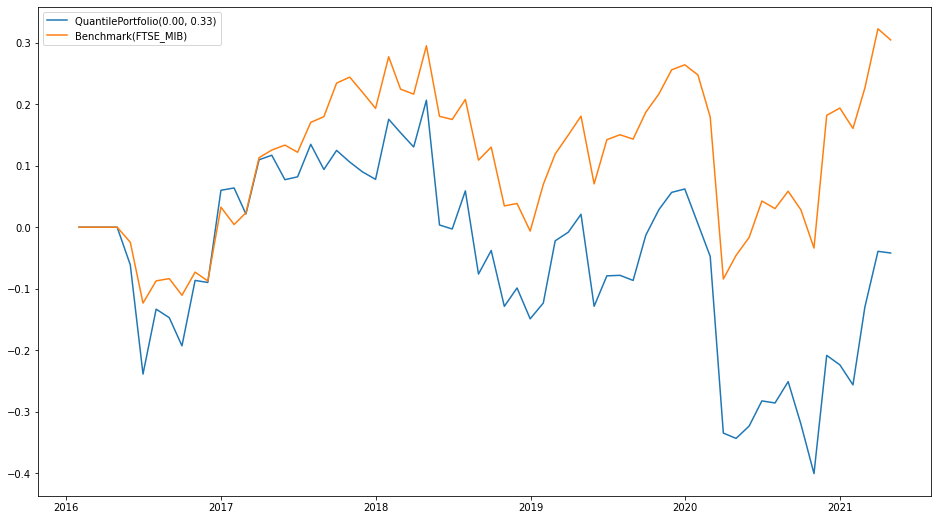

In [19]:
fm.portfolios[0].plot_cumulative_returns(add_benchmark=True)
plt.legend()

## Сравниваем портфели 
tabulate пришлось убрать, поскольку при отрисовке больше 3 портфелей у меня слетало форматирование из-за того, что вывод не помещался. Пока временно сделал табличку с помощью пандаса

,"QuantilePortfolio(0.00, 0.33)","QuantilePortfolio(0.33, 0.67)","QuantilePortfolio(0.67, 1.00)",WMLPortfolio()
"Alpha, %",-0.52,-0.03,0.02,-0.50
Alpha p-value,0.25,0.94,0.97,0.46
Beta,1.39,0.94,0.68,0.70
Beta p-value,0.00,0.00,0.00,0.00
Sharpe Ratio,0.13,0.29,0.28,-0.04
"Mean Return, %",0.35,0.53,0.43,-0.08
"Excessive Return, %",-0.26,-0.07,-0.18,-0.69
"Total Return, %",-4.20,23.39,20.42,-17.86
"Volatility, %",8.99,6.37,5.19,6.75
Benchmark Correlation,0.92,0.88,0.78,0.63


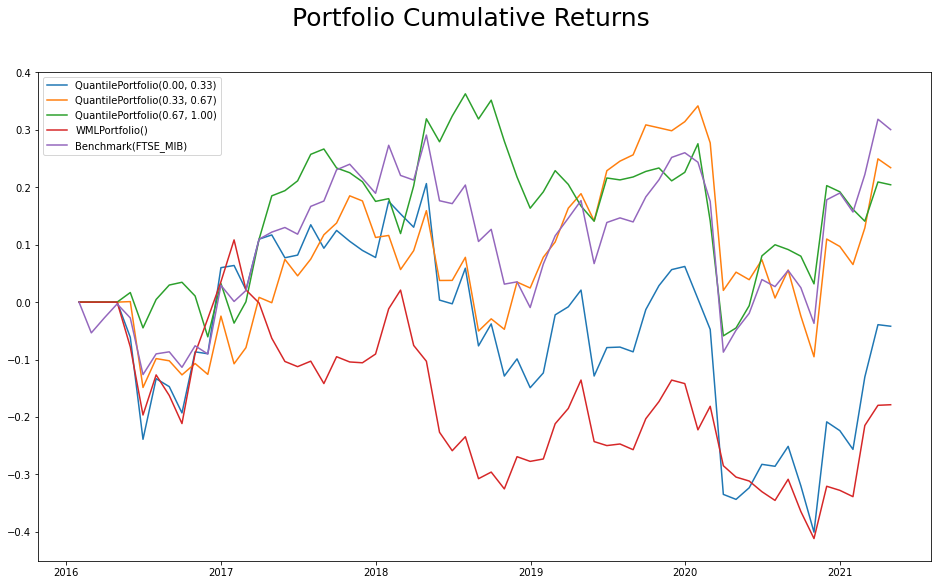

In [20]:
fm.compare_portfolios()

## Мультифакторы
Мультифактор принимает на вход список факторов класса Factor и name: str по умолчанию, но WeightedMultiFactor, также принимает список весов для каждого фактора (необязательно в сумме должны быть равны 1, т.к. внутри происходит нормировка, но все значения должны быть больше нуля)

### ! Важно: 
Мультифактор может содержать разнородные факторы (например, low_volatility и quality: от волатильности мы хотим наименьшее значение (bigger_better=False), а от quality - наибольшее (bigger_better=True)). 

В таком случае квантили для NSort и Intercept строятся относительно bigger_better: то есть если я хочу построить портфель на основе квантилей (0.8; 1), то это значит, что я беру (0.8, 1) по quality и (0, 0.2) по low_volatility (автоматически происходит "отзеркаливание" квантиля для фактора с bigger_better=False).

Если все факторы однородные (либо bigger_better=False для всех, либо bigger_better=True для всех), то портфель строится именно по тем квантилям, которые переданы.

Порядок передачи факторов также важен: для NSort мы сначала сортируем по 1 фактору, потом по 2 и т.д. (передавать можно сколько угодно факторов во все мультифакторы).

In [21]:
intercept = InterceptMultiFactor([value, size], name='intercept_value+size')
nsort = NSortMultiFactor([value, size], name='2sort_value+size')
weighted = WeightedMultiFactor([value, size], weights=[0.3, 0.7], name='weighted_value+size')

/home/akbabkin/notebooks/.datascience/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/akbabkin/PycharmProjects/pqr/pqr/factors/weightingfactor.py:19: RuntimeWarning: invalid value encountered in true_divide
  return weights / np.nansum(weights, axis=1)[:, np.newaxis]


,"QuantilePortfolio(0.00, 0.33)","QuantilePortfolio(0.33, 0.67)","QuantilePortfolio(0.67, 1.00)"
"Alpha, %",-0.24,0.21,-0.21
Alpha p-value,0.78,0.70,0.70
Beta,1.46,0.64,0.58
Beta p-value,0.00,0.00,0.00
Sharpe Ratio,0.21,0.36,0.10
"Mean Return, %",0.65,0.58,0.14
"Excessive Return, %",0.05,-0.03,-0.46
"Total Return, %",2.75,31.15,0.25
"Volatility, %",10.83,5.58,5.27
Benchmark Correlation,0.80,0.68,0.65


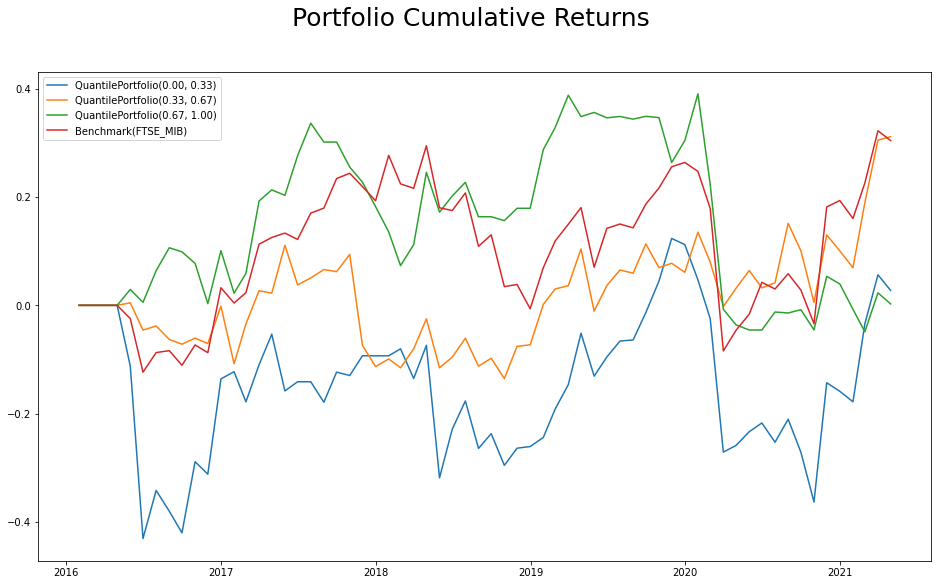

In [22]:
fm.fit(
    prices=prices,
    factor=intercept,
    filtering_factor=liquidity,
    weighting_factor=size_w,
    benchmark=benchmark
)
fm.compare_portfolios()

/home/akbabkin/notebooks/.datascience/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/akbabkin/PycharmProjects/pqr/pqr/factors/weightingfactor.py:19: RuntimeWarning: invalid value encountered in true_divide
  return weights / np.nansum(weights, axis=1)[:, np.newaxis]


,"QuantilePortfolio(0.00, 0.33)","QuantilePortfolio(0.33, 0.67)","QuantilePortfolio(0.67, 1.00)"
"Alpha, %",-0.62,-0.31,-0.16
Alpha p-value,0.45,0.60,0.79
Beta,1.39,0.57,0.59
Beta p-value,0.00,0.00,0.00
Sharpe Ratio,0.08,0.03,0.13
"Mean Return, %",0.25,0.05,0.21
"Excessive Return, %",-0.36,-0.56,-0.40
"Total Return, %",-17.01,-6.68,3.22
"Volatility, %",10.26,5.52,5.59
Benchmark Correlation,0.80,0.61,0.63


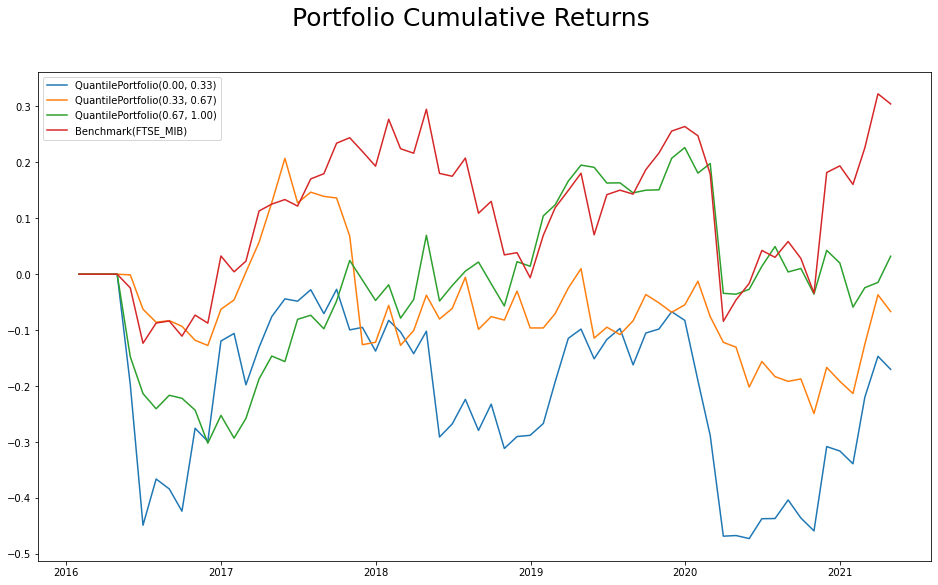

In [23]:
fm.fit(
    prices=prices,
    factor=nsort,
    filtering_factor=liquidity,
    weighting_factor=size_w,
    benchmark=benchmark,
)
fm.compare_portfolios()

/home/akbabkin/notebooks/.datascience/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/akbabkin/PycharmProjects/pqr/pqr/factors/weightingfactor.py:19: RuntimeWarning: invalid value encountered in true_divide
  return weights / np.nansum(weights, axis=1)[:, np.newaxis]


,"QuantilePortfolio(0.00, 0.33)","QuantilePortfolio(0.33, 0.67)","QuantilePortfolio(0.67, 1.00)"
"Alpha, %",-0.01,0.16,-0.65
Alpha p-value,0.99,0.58,0.01
Beta,1.09,0.82,1.13
Beta p-value,0.00,0.00,0.00
Sharpe Ratio,0.30,0.41,0.03
"Mean Return, %",0.65,0.64,0.07
"Excessive Return, %",0.04,0.03,-0.54
"Total Return, %",26.64,37.20,-11.29
"Volatility, %",7.42,5.36,7.06
Benchmark Correlation,0.88,0.91,0.95


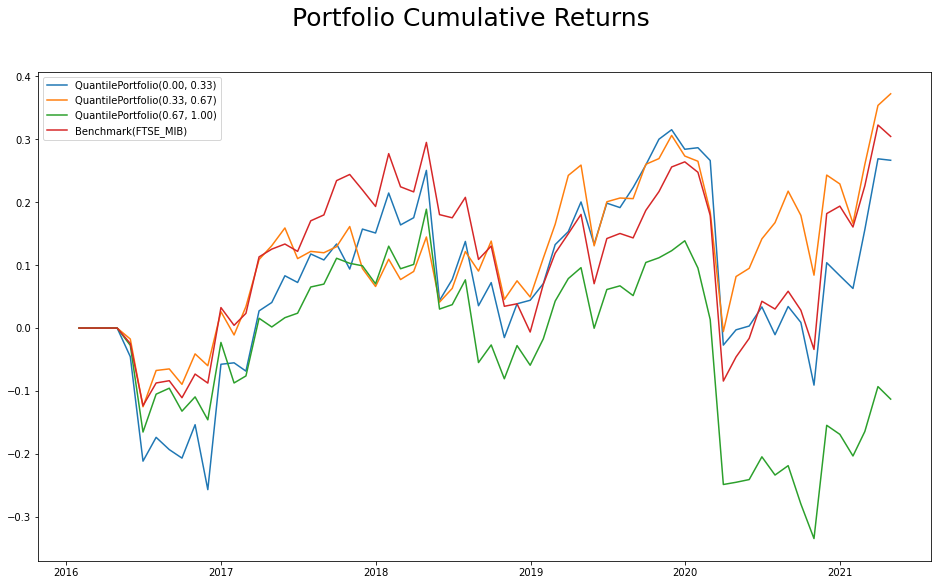

In [24]:
fm.fit(
    prices=prices,
    factor=weighted,
    filtering_factor=liquidity,
    weighting_factor=size_w,
    benchmark=benchmark
)
fm.compare_portfolios()

## grid_search
Метод класса FactorModel - принимает на вход сначала 3 списка/массива/чего угодно, по чему можно итерироваться; дальше все параметры повторяют параметры метода fit(). Возвращает словарь, в котором ключ - кортеж вида (1, 0, 1) - это, соответственно, looking_period, lag_period, holding_period, а значение - датафрейм с результатами (такой же, как и compare_portfolios()). 

Пока без распараллеливания работает неплохо: перебор всех адекватных параметров (50 комбинаций) занял всего 2.6 секунды, но и данные у меня не очень большие. Если возникнут проблемы со скоростью/памятью на реальных задачах - распараллелю (после рефакторинга это стало возможным).

In [25]:
%%time
%%capture

results = fm.grid_search(
    looking_periods=[1, 3, 6, 9, 12],
    lag_periods=[0, 1],
    holding_periods=[1, 3, 6, 9, 12],
    prices=prices,
    factor=value,
    filtering_factor=liquidity,
    weighting_factor=size_w,
    benchmark=benchmark
)

CPU times: user 2.62 s, sys: 10 ms, total: 2.63 s
Wall time: 2.63 s


In [26]:
results[(1, 0, 1)]

,"QuantilePortfolio(0.00, 0.33)","QuantilePortfolio(0.33, 0.67)","QuantilePortfolio(0.67, 1.00)"
"Alpha, %",-0.75,-0.18,-0.06
Alpha p-value,0.09,0.61,0.89
Beta,1.42,0.83,0.76
Beta p-value,0.00,0.00,0.00
Sharpe Ratio,0.09,0.24,0.28
"Mean Return, %",0.24,0.39,0.46
"Excessive Return, %",-0.37,-0.22,-0.15
"Total Return, %",-12.00,15.51,21.12
"Volatility, %",9.16,5.69,5.60
Benchmark Correlation,0.92,0.88,0.81


In [27]:
results[(12, 0, 12)]

,"QuantilePortfolio(0.00, 0.33)","QuantilePortfolio(0.33, 0.67)","QuantilePortfolio(0.67, 1.00)"
"Alpha, %",-0.15,0.66,-0.71
Alpha p-value,0.75,0.14,0.13
Beta,1.29,0.88,0.72
Beta p-value,0.00,0.00,0.00
Sharpe Ratio,0.28,0.63,-0.11
"Mean Return, %",0.62,1.02,-0.16
"Excessive Return, %",0.01,0.41,-0.77
"Total Return, %",22.59,73.16,-16.74
"Volatility, %",7.74,5.60,4.91
Benchmark Correlation,0.85,0.80,0.74
